# Creates a 3d array containing the different PSF's from used in deconvolving the LOFAR image

The PSF image is read in and the PSF's cutout from the image. They are then stored in a 3d array along with a seperate 3d array that stores the coordinates of the PSF's.

In [2]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
from astropy.convolution import Gaussian2DKernel
#import herschelhelp.cutouts_server as ctts
import scipy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting,utils
import pyvo as vo
import glob

import copy

In [3]:
def get_cutout_data_and_wcs(image,ra,dec,wcs,box_length):
    
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    length_x, length_y = image_plotting.get_pix_length(image,wcs,box_length,ra,dec)
    pix_cent_x, pix_cent_y = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    pixscale = np.array(wcs.wcs_pix2world(0,0,0)) - np.array(wcs.wcs_pix2world(1,1,0))
    if type(box_length)==list:
        imgcut = Cutout2D(image, c, size=[box_length[0]*u.degree,box_length[1]*u.degree], wcs=wcs)
    else:
        imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs
    imgcut = imgcut.data
    
    return(imgcut,wcscut)

In [4]:
lofar_orig = Table.read('../data/data_release/final_cross_match_catalogue-v1.0.fits')
print(len(lofar_orig))
lofar_orig[0]

31610


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,f

In [5]:
lofar_component = Table.read('../data/data_release/final_component_catalogue-v1.0.fits')
print(len(lofar_component))
lofar_component[0]

86000


Component_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Created,Deblended_from,Parent_Source
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes29,bytes22,bytes22
ILTJ153936.98+580651.7,234.90409574742577,58.11436685178417,0.000910655435717371,0.0010915293854267178,0.03887940165446956,0.014258139852887139,0.002666120985100087,0.0009167623793084566,S,0.008174848212191131,0.004976624331647756,138.96192976652347,0.002918164787813265,0.0016483856941018943,35.943946342848044,0.008003137446445173,0.004686688655986016,138.96192976652344,Ingest components,,ILTJ153936.98+580651.7


In [6]:
magphys_all_en1 = Table.read('../data/magphys/ELAIS_opt.fits')

In [7]:
fname = '../data/image_full_ampphase_di_m.NS.psf.fits'
hdulist = fits.open(fname)
radim_header_psf = hdulist[0].header
radim_wcs_psf = wcs.WCS(radim_header_psf).celestial
radim_data_psf = hdulist[0].data[0][0]
radim_pixsize = abs(radim_wcs_psf.wcs.cdelt[0])*3600
hdulist.close()

fname = '../data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()
radim_header['NAXIS']=2
radim_header['WCSAXES']=2

fname = '../data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header_err = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header_err).celestial
radim_err = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()

fname = '../data/data_release/image_full_ampphase_di_m.NS.mask01-2.fits'
hdulist = fits.open(fname)
radim_header_mask = hdulist[0].header
mask_deconv_wcs = wcs.WCS(radim_header_mask).celestial
mask_deconv = hdulist[0].data[0][0]
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


In [8]:
radim_header_psf

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                19845                                                  
NAXIS2  =                19845                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
WCSAXES =                    4 / Number of coordinate axes                      
CRPIX1  =               9923.0 / Pixel coordinate of reference point            
CRPIX2  =               9923.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CRPIX4  =                  1.0 / Pixel coordinate of reference point            
CDELT1  = -0.000416666666666

In [6]:
coords = np.array([3.860018, 0.625811,
3.791424, 0.658204,
3.771583, 0.645106,
3.732568, 0.544884,
3.726913, 0.590945,
3.828113, 0.663747,
3.883038, 0.643358,
3.743820, 0.662555,
3.737862, 0.534082,
3.762850, 0.566185,
3.812650, 0.638268,
3.726524, 0.611372,
3.847929, 0.605437,
3.814480, 0.660685,
3.799528, 0.668176,
3.861133, 0.595614,
3.826830, 0.637051,
3.735226, 0.562418,
3.853990, 0.563771,
3.880732, 0.576210,
3.763789, 0.614934,
3.759293, 0.581030,
3.770424, 0.665688,
3.764894, 0.551401,
3.774556, 0.609715,
3.858146, 0.639105,
3.808728, 0.561829,
3.748218, 0.670049,
3.733927, 0.577404,
3.880513, 0.621074,
3.836240, 0.576863,
3.854241, 0.541666,
3.746691, 0.641780,
3.832805, 0.537712,
3.780852, 0.629812,
3.877034, 0.540584,
3.785497, 0.572498,
3.881176, 0.597392,
3.749032, 0.625621,
3.783302, 0.554616,
3.775236, 0.591133,
3.766964, 0.625425,
3.785732, 0.538470,
3.816849, 0.553878,
3.876768, 0.560066])*180/np.pi

psf_coords = []
for n in range(int(len(coords)/2)):
    n_ra = n*2
    n_dec = n*2 + 1
    coord = []
    coord.append(coords[n_ra])
    coord.append(coords[n_dec])
    psf_coords.append(coord)
psf_coords = np.array(psf_coords)

In [9]:
plot_params = {'marker':['o','+','o','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/120,
              'use_redshift':[False,False,False,False]}

221.16274024452903 35.85632907286156


<Figure size 504x504 with 0 Axes>

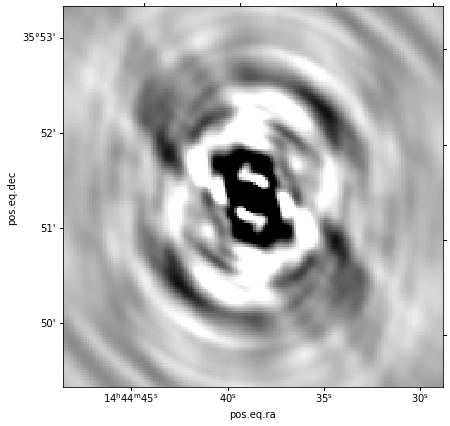

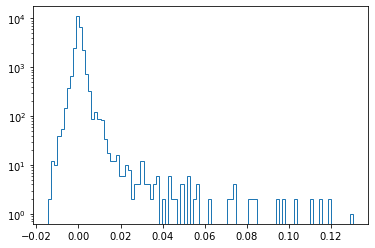

217.23259354460865 37.71231125862884


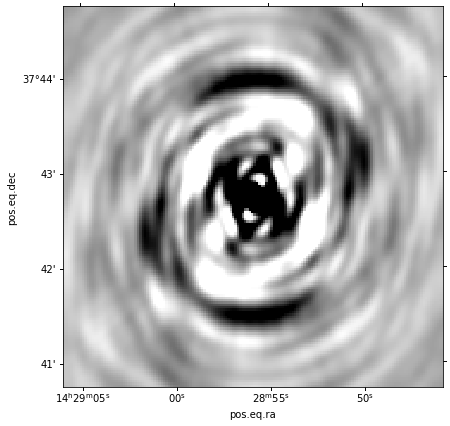

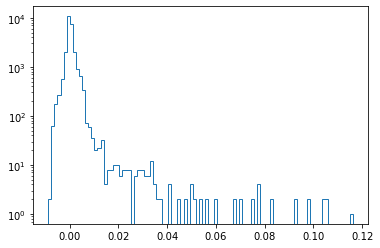

216.09578798328957 36.96185113856649


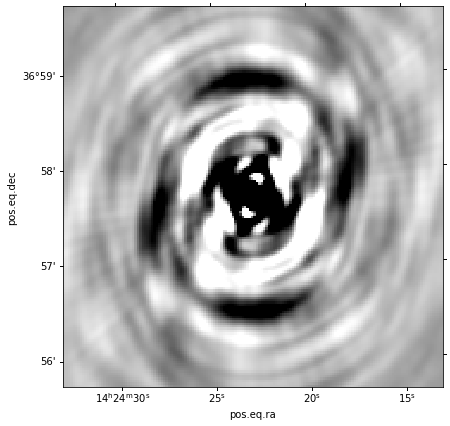

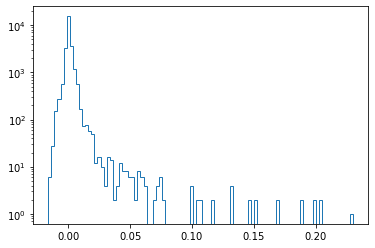

213.86039314558667 31.21955352420635


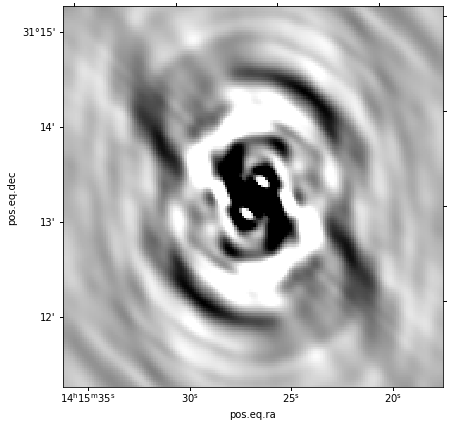

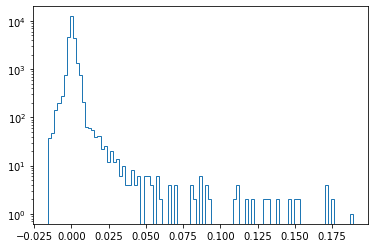

213.53638551244018 33.858654424358434


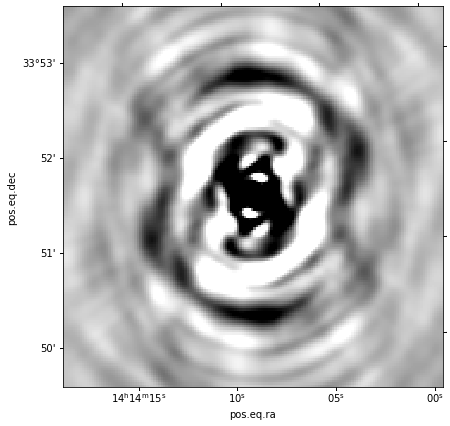

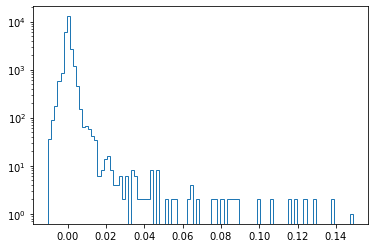

219.3347183991641 38.02990176446985


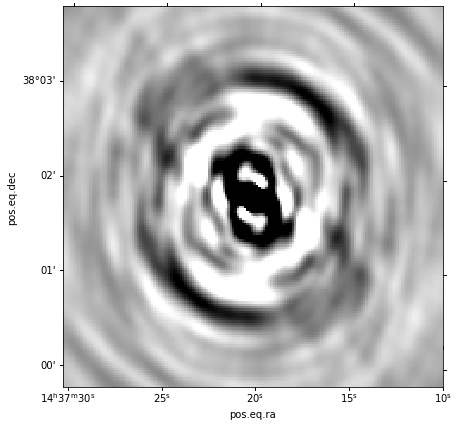

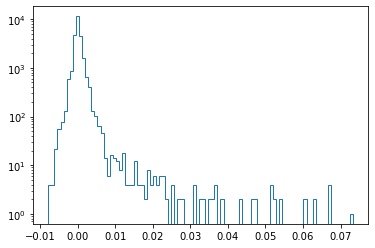

222.48168908892015 36.86169811597762


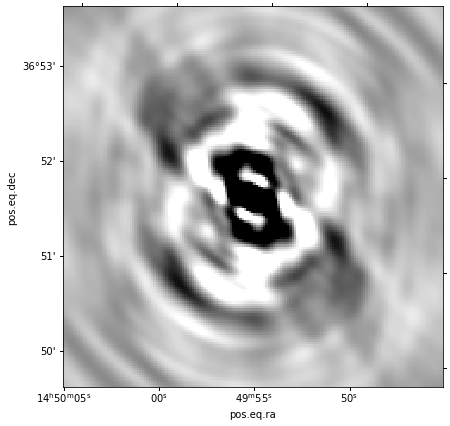

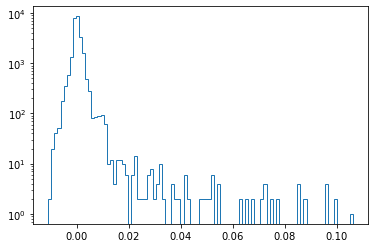

214.50508525666788 37.96160519529026


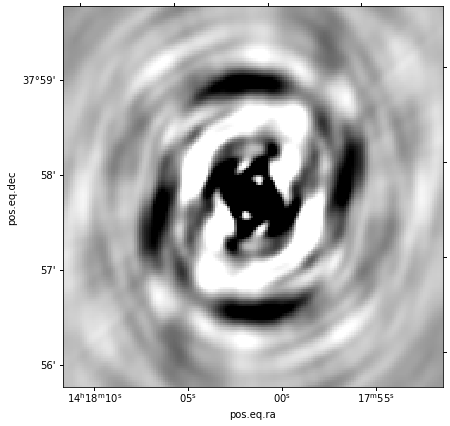

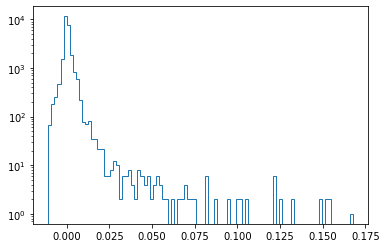

214.16371700232892 30.60064451390603


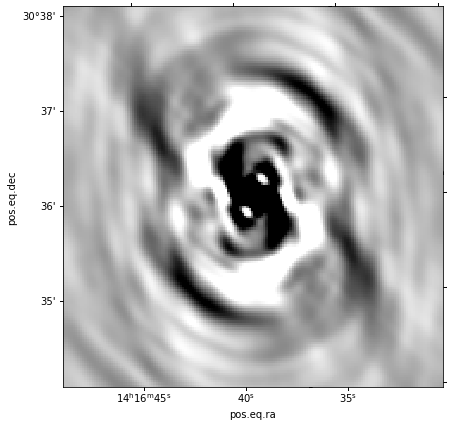

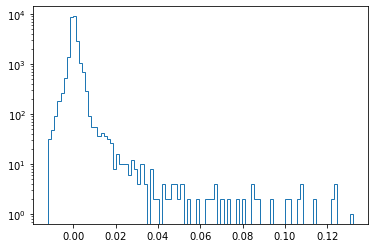

215.59542394080182 32.440010923614516


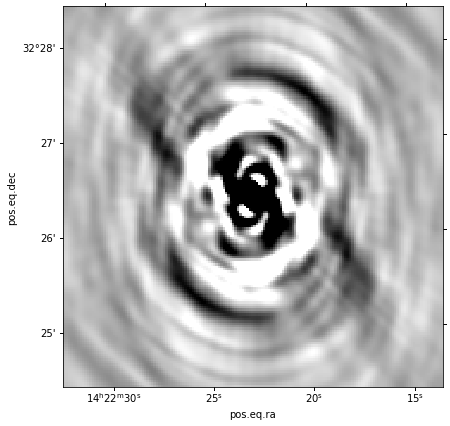

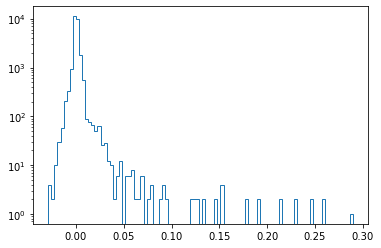

218.44875376055333 36.57006259825603


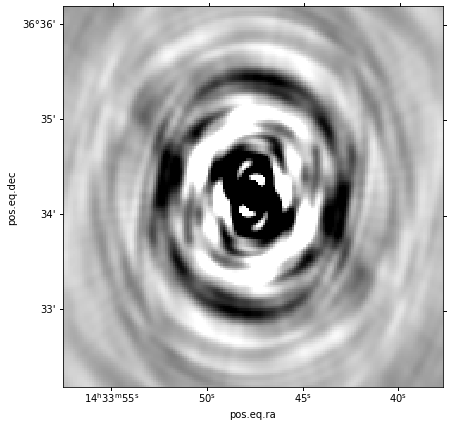

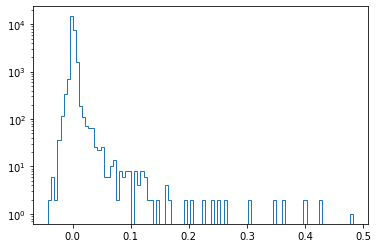

213.51409745420958 35.02903531247217


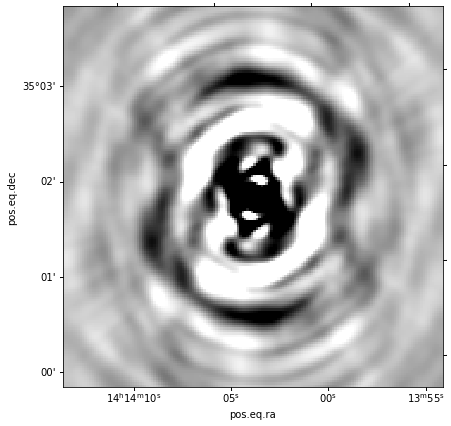

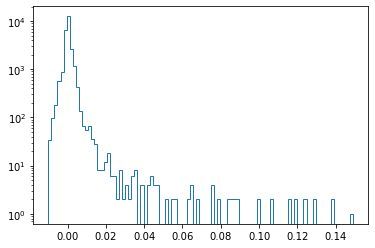

220.47009156599538 34.688984861062025


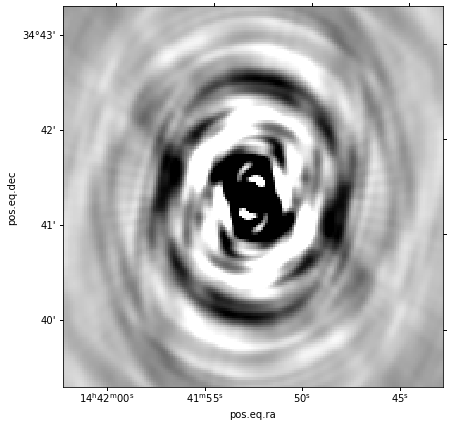

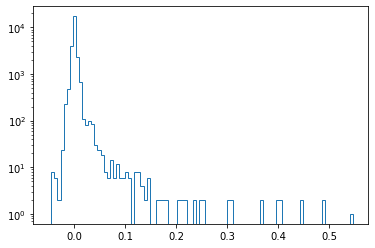

218.55360503706225 37.854462087600794


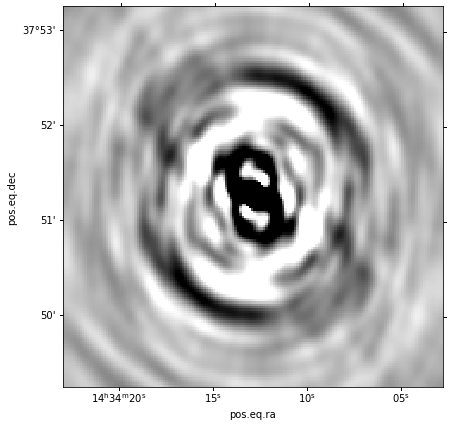

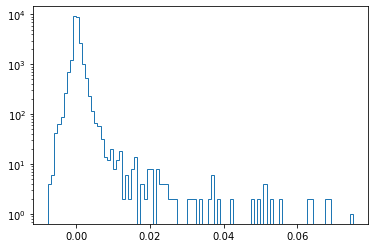

217.69691854178265 38.283664771933296


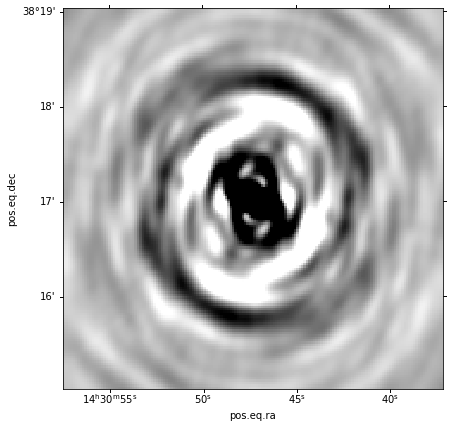

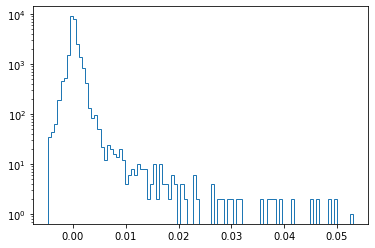

221.2266250386861 34.12616841890502


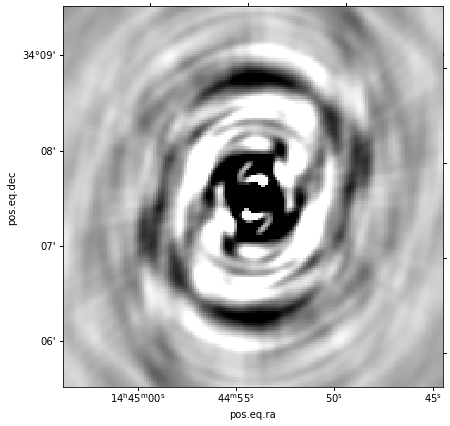

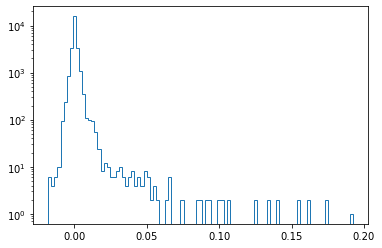

219.26120791404884 36.500333634588614


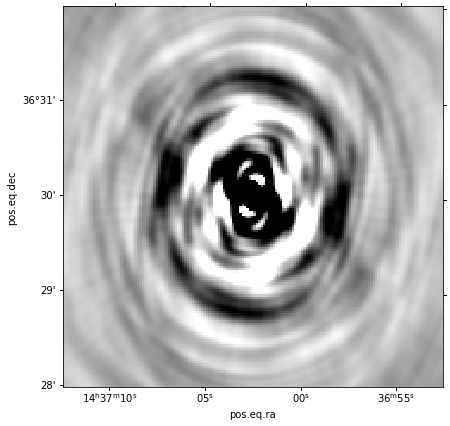

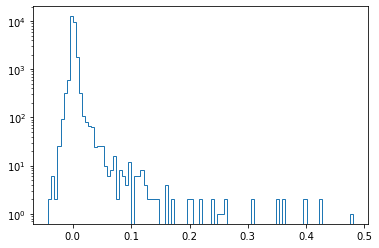

214.01268532753244 32.22417772218873


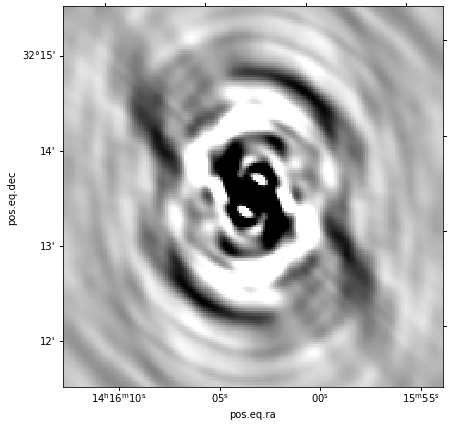

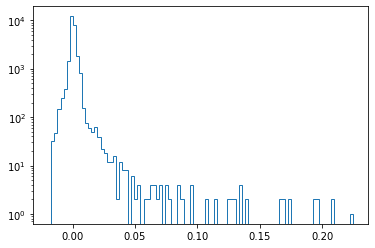

220.81736128562414 32.301698911869934


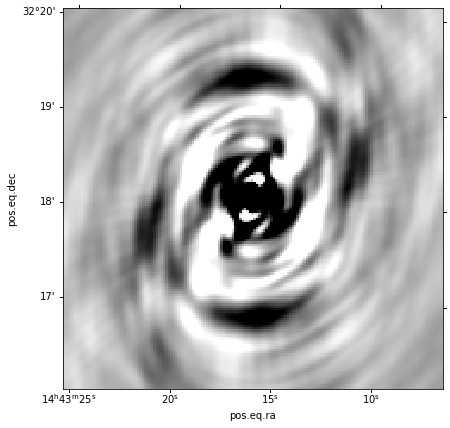

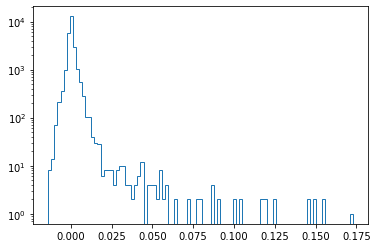

222.349565021363 33.01440111323316


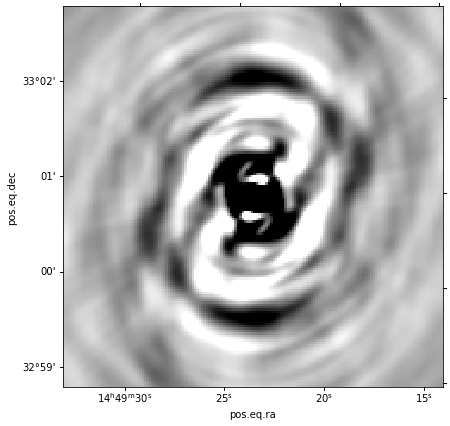

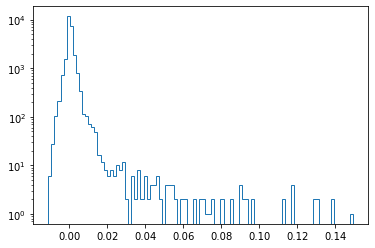

215.6492246777646 35.23312287909776


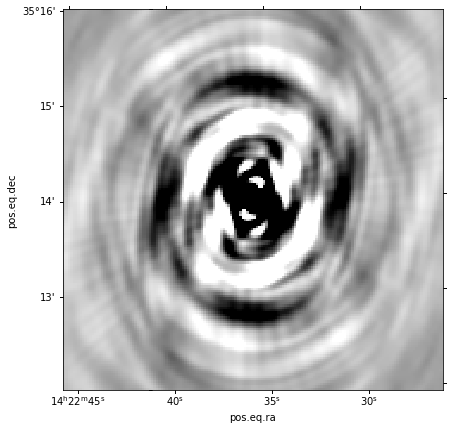

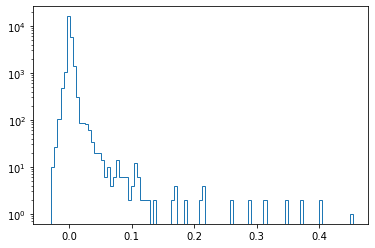

215.39162285307378 33.29056677048622


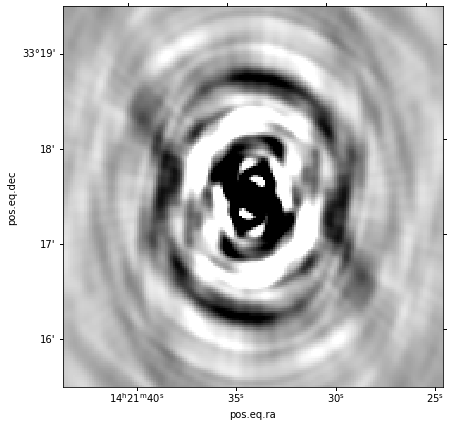

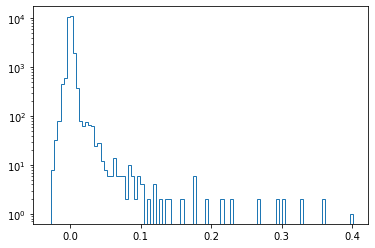

216.02938217483393 38.14111287250474


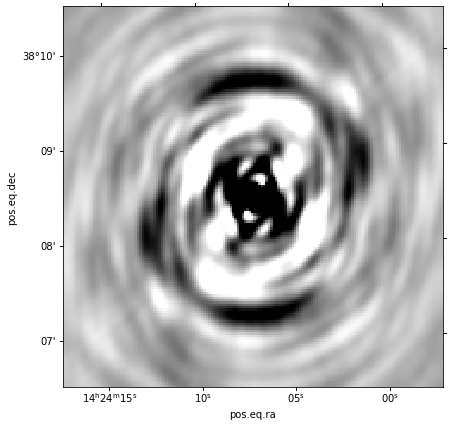

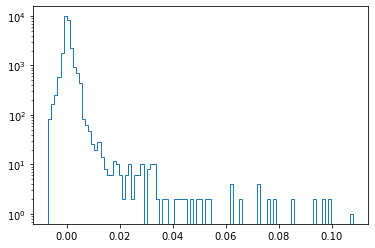

215.71253651412655 31.59295011929311


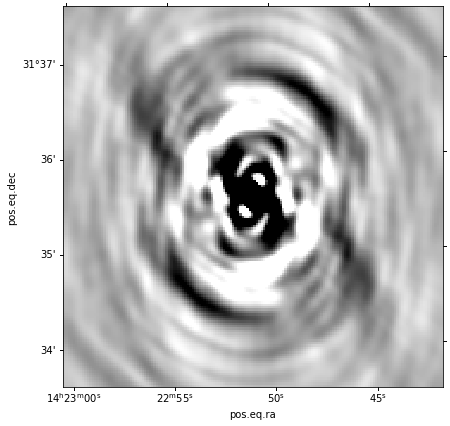

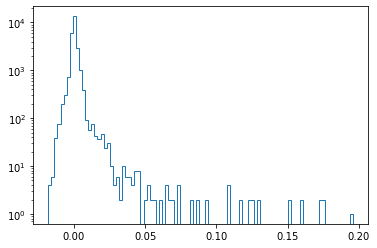

216.26612833578196 34.93409620581899


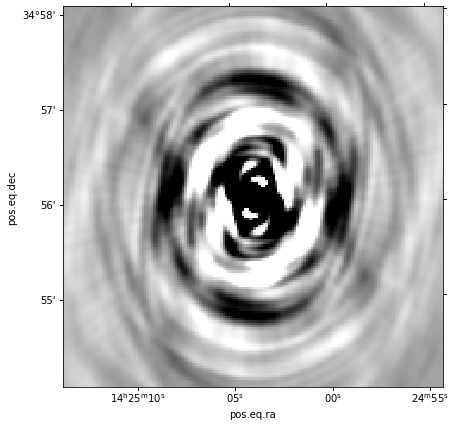

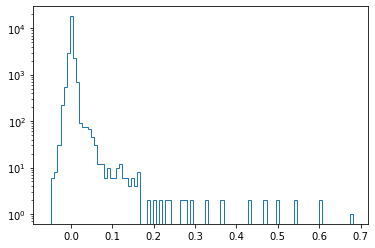

221.0554825452805 36.61801916570848


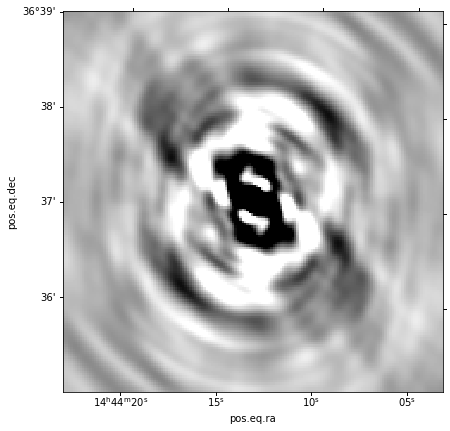

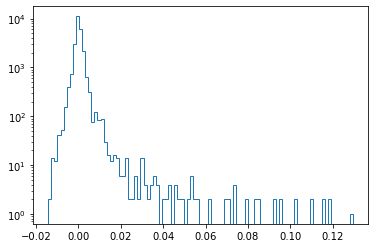

218.224039713303 32.19043050805553


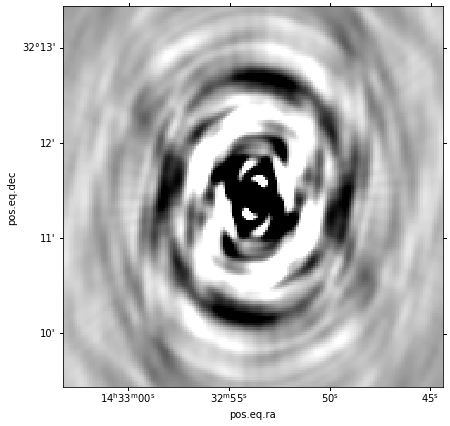

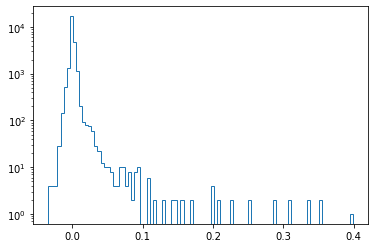

214.75707209496642 38.390979766961294


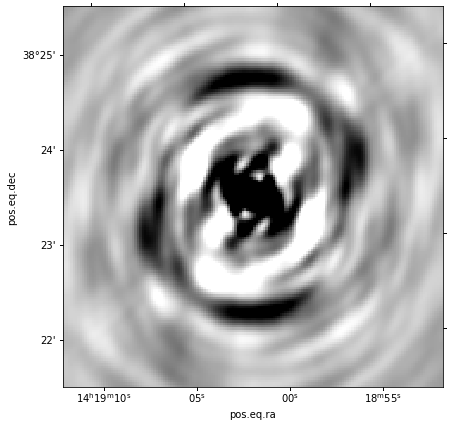

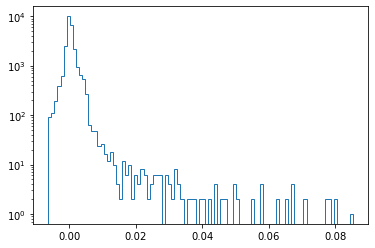

213.93825810994494 33.08281227397179


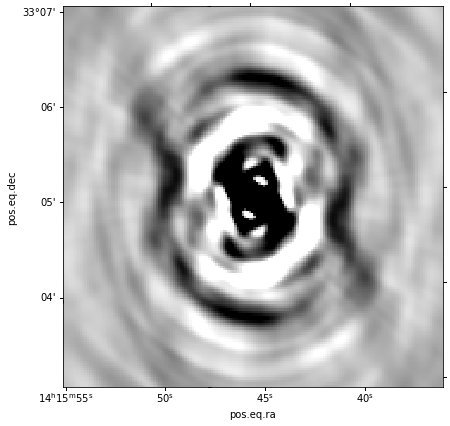

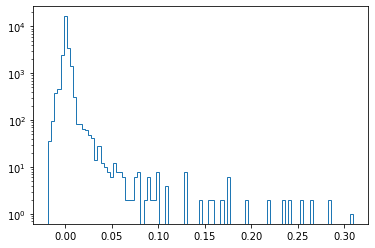

222.33701724564963 35.58491896530809


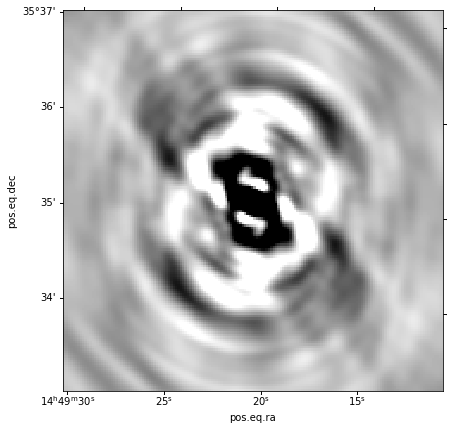

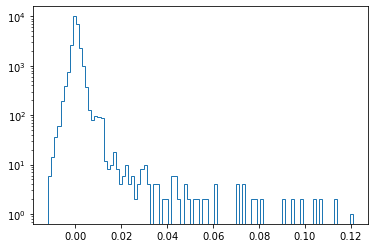

219.80036119926692 33.05181525725521


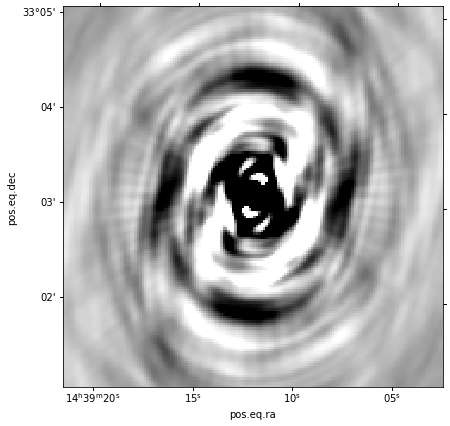

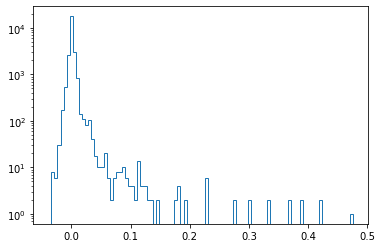

220.83174252628191 31.035175705733245


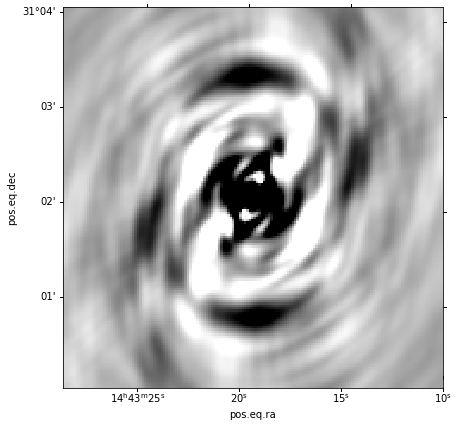

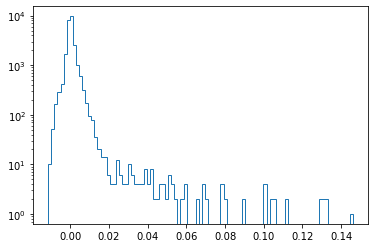

214.66958143964993 36.771285375905975


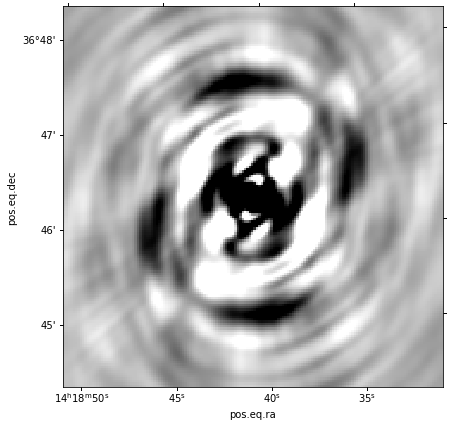

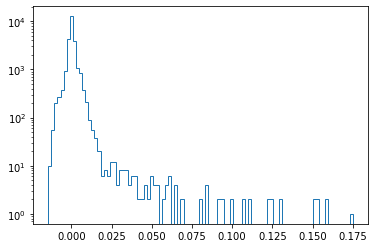

219.6035501966395 30.80862819353852


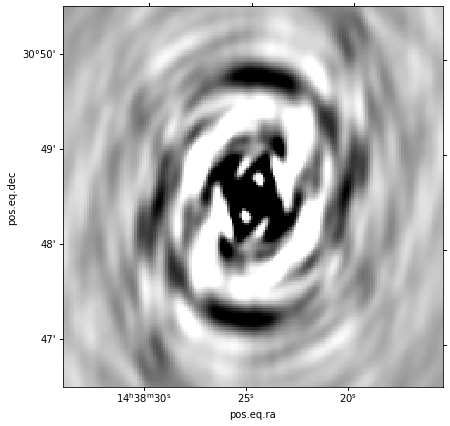

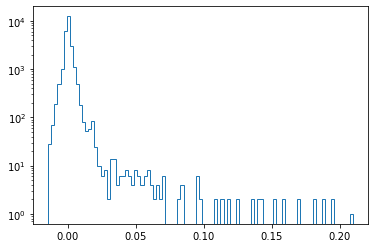

216.62686256359632 36.08556948669341


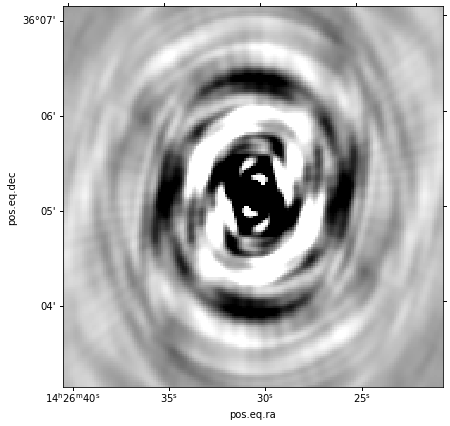

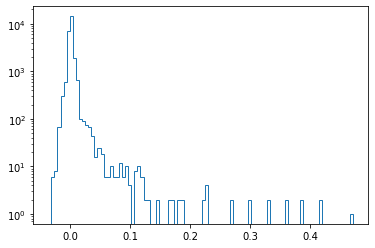

222.13768522872363 30.97318167230009


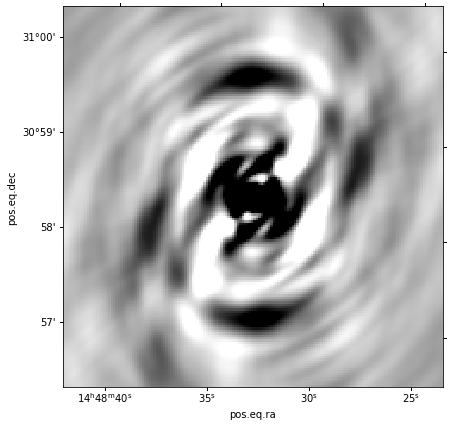

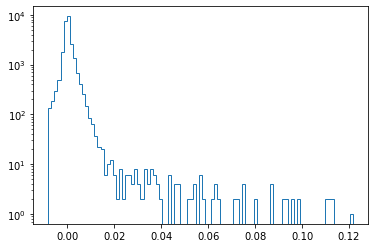

216.8930014594346 32.8017191796806


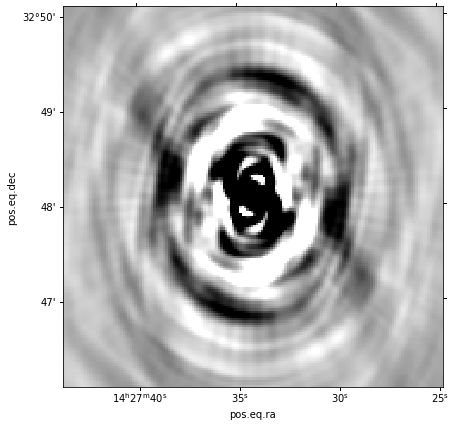

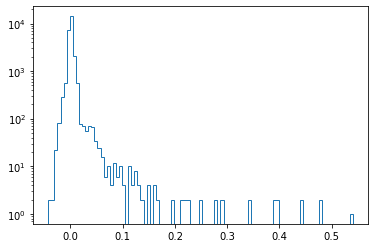

222.37500434746678 34.22804031487928


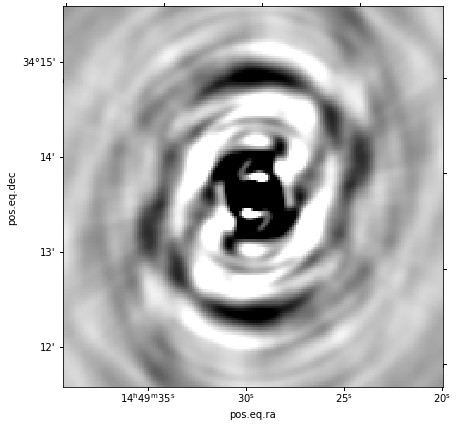

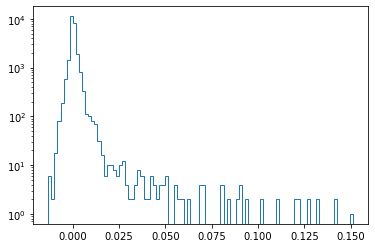

214.80371085949005 35.84544287475408


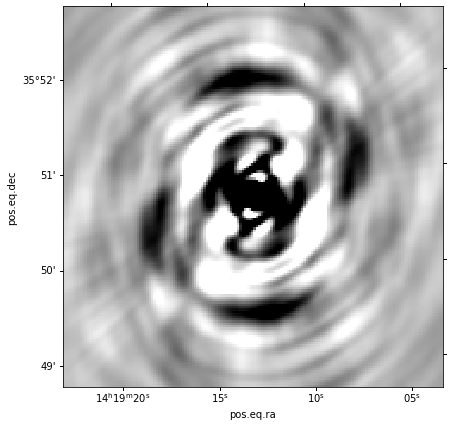

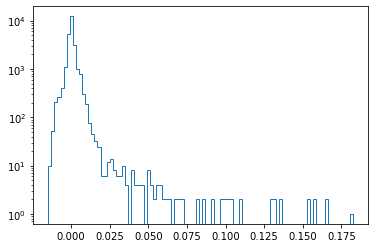

216.76723722340338 31.777156050427664


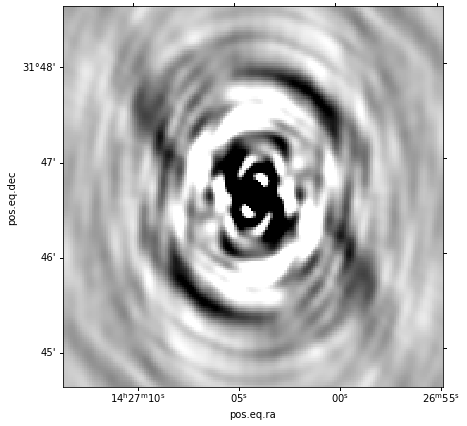

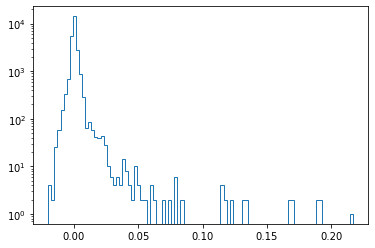

216.30508946585084 33.869426030906894


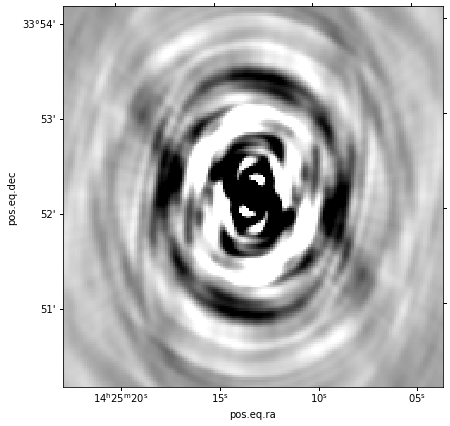

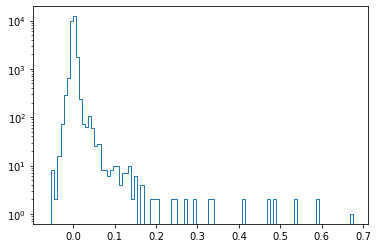

215.83113877771865 35.83421290196951


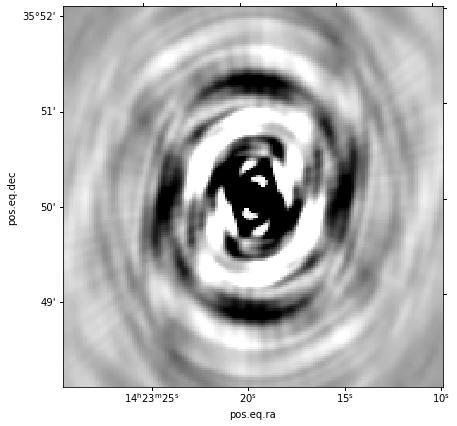

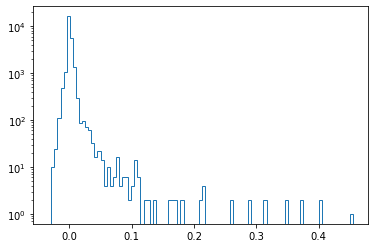

216.90646596762016 30.852058394409436


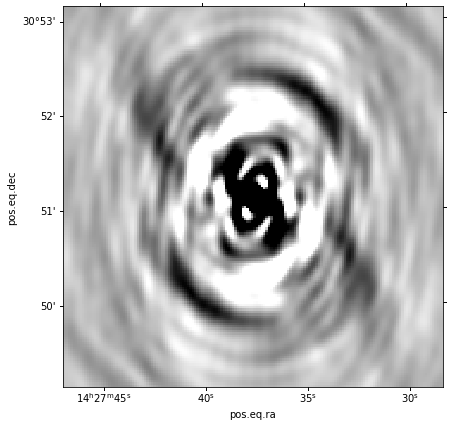

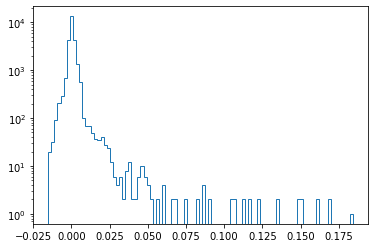

218.68933873872876 31.73487176514701


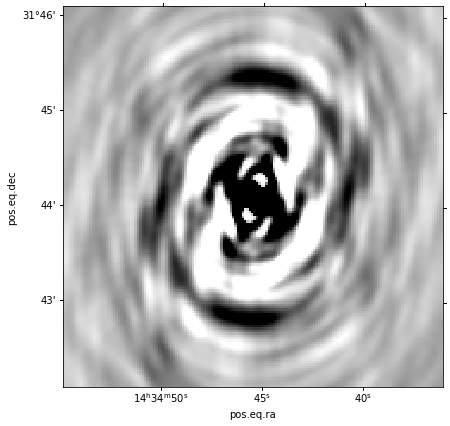

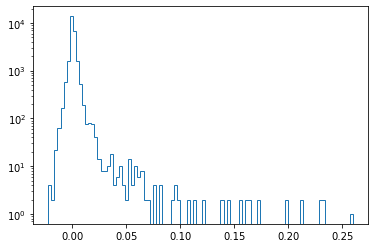

222.12244455137315 32.08941804877396


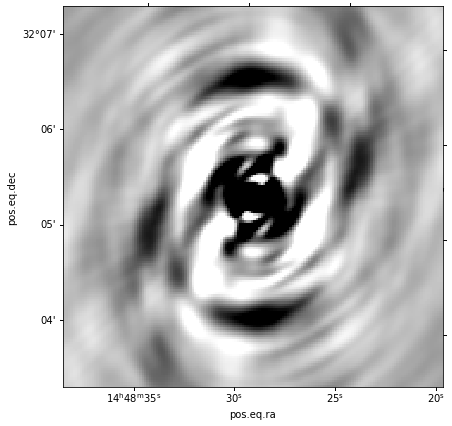

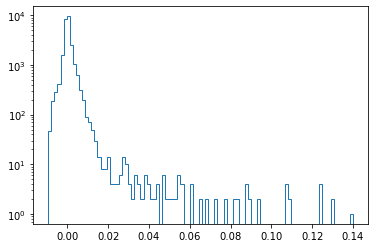

In [10]:
fig = plt.figure(figsize=[7,7])
ra = psf_coords[:,0]
dec = psf_coords[:,1]
box_length = 1/15
for n in range(len(ra)):
    #image_plotting.plot_figure(radim_data,psf_coords,radim_wcs,ra[n],dec[n],plot_params)
    fig = plt.figure(figsize=[7,7])
    print(ra[n],dec[n])
    image_plotting.image_plot(radim_data_psf,ra[n],dec[n],radim_wcs_psf,box_length,fig)
    plt.show()
    
    imgcut,wcscut = get_cutout_data_and_wcs(radim_data_psf,ra[n],dec[n],radim_wcs_psf,box_length)
        
    bins=np.arange(-1.1,-0.5,0.01)
    bins=np.linspace(np.min(imgcut)-np.min(imgcut)/100,np.max(imgcut)+np.max(imgcut)/100,100)
    plt.hist(imgcut.flatten(),bins=bins,histtype='step',log=True)
    #plt.vlines(0.1,ymin=0,ymax=100,color='black')
    plt.show()

In [11]:
ra = psf_coords[:,0]
dec = psf_coords[:,1]

lengths = [15,30,60,120,240]

psfs = []
for m in range(len(ra)):
    nums = []

    box_length = 1/30

    imgcut,wcscut = get_cutout_data_and_wcs(radim_data_psf,ra[m],dec[m],radim_wcs_psf,box_length)

    if (imgcut.shape[0]%2==0) or (imgcut.shape[1]%2==0):
        box_length_x = box_length + (1-imgcut.shape[0]%2)*(radim_pixsize/3600)
        box_length_y = box_length + (1-imgcut.shape[1]%2)*(radim_pixsize/3600)
        box_length = [box_length_y,box_length_x]
        imgcut,wcscut = get_cutout_data_and_wcs(radim_data_psf,ra[m],dec[m],radim_wcs_psf,box_length)

    
    psf_lim = 0.01

    mask = imgcut<psf_lim
    psf = imgcut
    psf[mask] = 0

    psfs.append(psf)
        
    '''nums.append(np.sum(imgcut>psf_lim))

        if n>0:
            if nums[n]-nums[n-1]==0:
                psfs.append(imgcut)
                break'''

psfs = np.array(psfs)
#[print(psf.shape[0],psf.shape[1]) for psf in psfs if (psf.shape[0]%2==0) or (psf.shape[1]%2==0)]

In [ ]:
argmax = np.argmax(psfs[0],axis=0)
rowmax = [row[argmax[n]] for n,row in enumerate(psfs[0])]
np.argmax(rowmax)

Dump the cut down PSF and coords into a pickle file

In [ ]:
pixsizes = [radim_pixsize for n in range(len(psfs))]
pickle.dump( [psfs,coords,pixsizes], open( "data/PSF_coords.pkl", "wb" ) )

#old method to select psf cutouts that doesn't set small contributions to zero

fig = plt.figure(figsize=[7,7])
ra = psf_coords[:,0]
dec = psf_coords[:,1]

lengths = [15,30,60,120,240]

psfs = []
for m in range(2):
    nums = []
    for n,length in enumerate(np.arange(1/120,1/15,1/600)):

        box_length = length

        imgcut,wcscut = get_cutout_data_and_wcs(radim_data,ra[m],dec[m],radim_wcs,box_length)
        print(imgcut)

        psf_lim = 0.01
        nums.append(np.sum(imgcut>psf_lim))

        if n>0:
            if nums[n]-nums[n-1]==0:
                psfs.append(imgcut)
                break





In [ ]:
radim_data.shape
ra,dec = radim_wcs.wcs_pix2world([7000],[7000],0)


In [ ]:
plot_params = {'marker':['o','+','o','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False,False]}

fig = plt.figure(figsize=[7,7])
print(ra,dec)
box_length = 1/240

wcs_plot,ax = image_plotting.image_plot(radim_data,ra,dec,radim_wcs,box_length,fig)
image_plotting.cat_plot(ra,dec,wcs_plot,ax,marker='x')
plt.show()

In [ ]:
def create_test_prior_single(ra,dec,image,err,header):
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)  
    import pymoc
    moc=pymoc.util.catalog.catalog_to_moc(c,60,15)
    
    mask = ~np.isnan(image)
    image[mask] = 0
    
    prior = xidplus.prior(image,err,'tmp',header,moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
    prior.prior_cat(np.array([ra,ra]),np.array([dec,dec]),'prior_cat',ID=np.array(['test_source_1','test_source_2']))#Set input catalogue
    
    return(prior)

In [ ]:
prior = create_test_prior_single(np.array([242.75]),np.array([55]),radim_data,radim_err,radim_header)

#prior = pickle.load(open('test_prior_prf.pkl','rb'))

In [ ]:
pickle.dump(prior,open( "test_prior_prfs.pkl", "wb" ))

In [ ]:
test_psf_1 = np.array([[0.5,0.5,0.5],[0.5,1.0,0.5],[0.5,0.5,0.5]])
test_psf_2 = np.array([[5,5,5],[5,10,5],[5,5,5]])
test_pixsize = np.arange(0,3,1)*1.5
prior.set_prfs(np.array([test_psf_1,test_psf_2]),np.array([test_pixsize,test_pixsize]),np.array([test_pixsize,test_pixsize]))

In [ ]:
get_pointing_matrix_multiple_prf(prior)

In [ ]:
def get_pointing_matrix_multiple_prf(self, bkg=True):
    """Calculate pointing matrix. If bkg = True, bkg is fitted to all pixels. 
    If False, bkg only fitted to where prior sources contribute
    """
    from scipy import interpolate

    amat_row = np.array([], dtype=int)
    amat_col = np.array([], dtype=int)
    amat_data = np.array([])

    # ------Deal with PRF array----------

    # create pointing array
    for s in range(0, self.nsrc):

        paxis1, paxis2 = self.prfs[s].shape
        centre = ((paxis1 - 1) / 2)

        # diff from centre of beam for each pixel in x
        dx = -np.rint(self.sx[s]).astype(np.long) + self.pindxs[s][np.rint((paxis1 - 1.) / 2).astype(np.long)] + self.sx_pix
        # diff from centre of beam for each pixel in y
        dy = -np.rint(self.sy[s]).astype(np.long) + self.pindys[s][np.rint((paxis2 - 1.) / 2).astype(np.long)] + self.sy_pix

        # diff from each pixel in prf
        pindx = self.pindxs[s] + self.sx[s] - np.rint(self.sx[s]).astype(np.long)
        pindy = self.pindys[s] + self.sy[s] - np.rint(self.sy[s]).astype(np.long)
        print(pindx)


        good = (dx >= 0) & (dx < self.pindxs[s][paxis1 - 1]) & (dy >= 0) & (dy < self.pindys[s][paxis2 - 1])
        ngood = good.sum()
        bad = np.asarray(good) == False
        nbad = bad.sum()
        ipx2, ipy2 = np.meshgrid(pindx, pindy)
        print(pindx)
        print(ipx2.ravel().shape)
        print(ipy2.ravel().shape)
        print(self.prfs.ravel().shape)
        atemp = interpolate.griddata((ipx2.ravel(), ipy2.ravel()), self.prfs[s].ravel(), (dx[good], dy[good]),
                                         method='nearest')

        if atemp.size > 0:
            keep=atemp > np.max(atemp)/1.0E3
            amat_data = np.append(amat_data, atemp[keep])
            amat_row = np.append(amat_row,np.arange(0, self.snpix, dtype=int)[good][keep])  # what pixels the source contributes to
            amat_col = np.append(amat_col, np.full(keep.sum(), s))  # what source we are on


    self.amat_data = amat_data
    self.amat_row = amat_row
    self.amat_col = amat_col

In [ ]:
get_pointing_matrix_multiple_prf(prior)

In [ ]:
prior.amat_data

In [ ]:
prior.sx
prior.sy

In [ ]:
prior.amat_data

## Generate PSFs for sources that have been deconvolved

Deconvolved sources have a gaussian PSF that is determined from the Positional Angle and the major and minor radius column

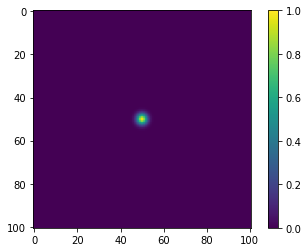

In [7]:
#generate a psf for the first object in the catalogue 
n = 5
n_size = 101
FWHM_factor = 2*np.sqrt(2*np.log(2))
sig_maj = 4/FWHM_factor#/2.355
sig_min = 6/2.355


prf = Gaussian2DKernel(sig_maj,x_size=n_size,y_size=n_size)
prf.normalize(mode='peak')

plt.imshow(prf.array)
plt.colorbar()
plt.show()


239.9927239172247 55.01816041112506


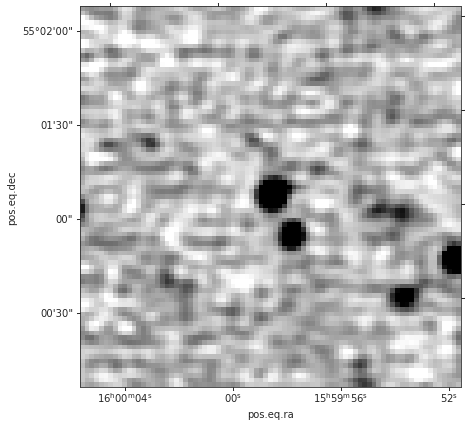

In [270]:
plot_params = {'marker':['o','+','o','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False,False]}
n=1
fig = plt.figure(figsize=[7,7])
ra = lofar_orig['RA'][n]
dec = lofar_orig['DEC'][n]
print(ra,dec)
box_length = 1.5/3600*n_size

wcs_plot,ax = image_plotting.image_plot(radim_data,ra,dec,radim_wcs,box_length,fig)
#wcs_plot,ax = image_plotting.image_plot(mask_deconv,ra,dec,mask_deconv_wcs,box_length,fig)
#plt.contour(prf.array,color='red')
plt.show()

## Find sources that we want to include in our prior list

We include all previosly deetcted radio sources and sources with a magphys sed fit (IRAC selected) that have a predicted radio flux <20uJy. We predict their radio flux assuming q=1.9

#### ToDo correct q assumption to account for nonlinearity

In [92]:
#convert Ldust to radio luminosity
q = 1.9
lradio = np.log10(magphys_all_en1['Ldust_bayes']*3.8E26) - np.log10(3.75E12) - q
#predict flux at 150MHz observed frame in Jy
redshift = magphys_all_en1['z']
dist = cosmo.luminosity_distance(redshift).to(u.m).value
alpha = -0.6
flux_radio = 10**lradio / (4*np.pi*dist**2 * (1+redshift)**(-1-alpha))

flux_radio = flux_radio/1E-26

#create a mask that selects galaxies whose predicted flux at 150MHz is above f_lim
f_lim = 100
mask_detectable = flux_radio > f_lim*1E-6
print('There are {} sources with a predicted flux measured at 150MHz that are >{}uJy'.format(np.sum(mask_detectable),f_lim))

There are 28021 sources with a predicted flux measured at 150MHz that are >100uJy


## Try running XID+ on the lofar image

In [8]:
lofar_orig

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,f

In [728]:
n = 5
mask = lofar_orig['DC_Maj']>0.0
ras = lofar_orig['RA'][mask][n:n+1]
decs = lofar_orig['DEC'][mask][n:n+1]
print(len(ras))
ID = lofar_orig['Source_Name'][mask][n:n+1]


orig_fluxes = lofar_orig['Peak_flux'][mask][n:n+1]
orig_ferr = lofar_orig['E_Peak_flux'][mask][n:n+1]

1


In [729]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,30,15)

In [730]:
prior=xidplus.prior(radim_data,radim_err,radim_header,radim_header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior.prior_cat(ras,decs,'prior_cat',ID=ID,moc=moc)#Set input catalogue
prior.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

In [731]:
pind = np.arange(0,n_size)#*(1.0/radim_pixsize)
prior.set_prf(prf.array,pind,pind)

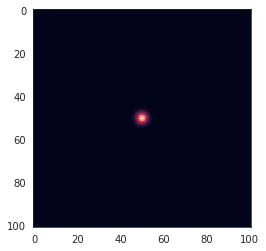

In [732]:
plt.imshow(prf)

In [733]:
print('fitting '+ str(prior.nsrc)+' sources \n')
print('using ' +  str(prior.snpix) + ' pixels')




fitting 1 sources 

using 1293 pixels


In [734]:
prior.get_pointing_matrix()
prior.upper_lim_map()

In [735]:
from xidplus.numpyro_fit import LOFAR150
fit=LOFAR150.LOFAR_150(prior,num_samples=1000,num_warmup=1000)

In [736]:
samples = fit.get_samples()['src_f']

In [737]:
f_source = np.median(samples[2000:,:,:],axis=0)
f_err = np.percentile(samples[2000:,:,:],84,axis=0) - np.percentile(samples[2000:,:,:],16,axis=0)
print(f_source,f_err)

[[0.09327134]] [[0.01556869]]


In [738]:
print(orig_fluxes*1000,orig_ferr*1000)

     Peak_flux     
-------------------
0.08087973788675171     E_Peak_flux    
-------------------
0.02438145615441711


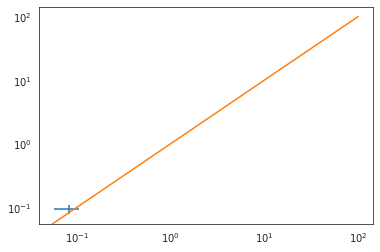

In [739]:
x = orig_fluxes*1000
xerr = orig_ferr*1000
y = f_source
yerr = f_err.flatten()

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='')
plt.plot([0,100],[0,100])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [740]:
posterior = xidplus.posterior_numpyro(fit,[prior])

Number of divergences: 0


([<aplpy.core.FITSFigure at 0x2aadcdd64f50>],
 <Figure size 720x720 with 2 Axes>)

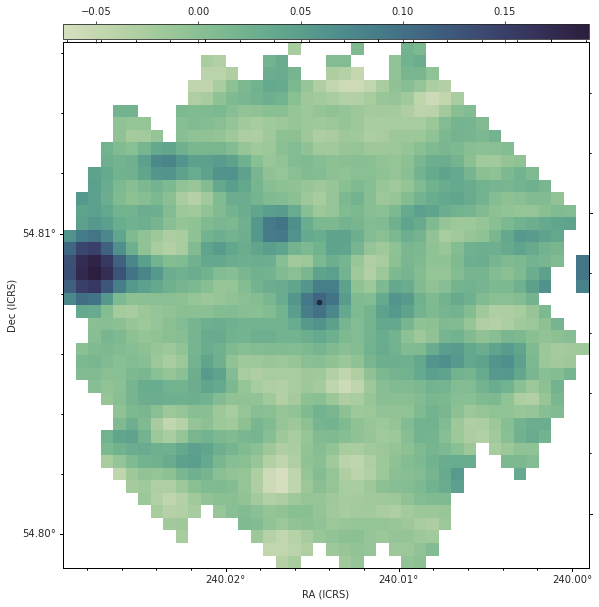

In [741]:
xidplus.plot_map([prior])

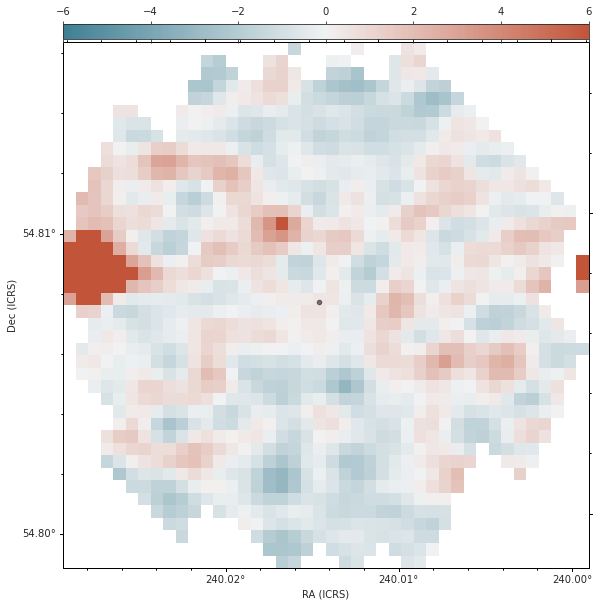

In [742]:
figs,fig=xidplus.plot_Bayes_pval_map([prior], posterior)

In [231]:
for n in ['3','4']:
    for val in ['RPIX','DELT','UNIT','TYPE','RVAL']:
        try:
            radim_header.remove('C{}{}'.format(val,n))
        except:()
radim_header.remove('NAXIS3')
radim_header.remove('NAXIS4')
radim_header['NAXIS']=2
radim_header['WCSAXES']=2

## Run XID+ on the same source but include all sources within 120"

1


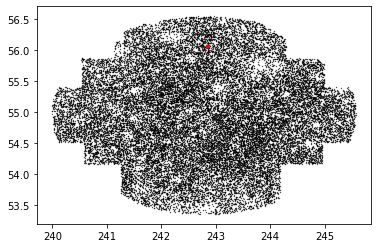

In [23]:
n = 10000
mask = lofar_orig['DC_Maj']>0.0
ras = lofar_orig['RA'][mask][n:n+1]
decs = lofar_orig['DEC'][mask][n:n+1]
print(len(ras))
ID = lofar_orig['Source_Name'][mask][n:n+1]


orig_fluxes = lofar_orig['Peak_flux'][mask][n:n+1]
orig_ferr = lofar_orig['E_Peak_flux'][mask][n:n+1]

x = lofar_orig['RA']
y = lofar_orig['DEC']
plt.scatter(x,y,s=0.1,c='black')

x = ras
y = decs
plt.scatter(x,y,s=10,c='red')
plt.show()

from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc_near=pymoc.util.catalog.catalog_to_moc(c,60,15)

moc_mask = inMoc(lofar_orig['RA'],lofar_orig['DEC'],moc_near)
moc = pymoc.util.catalog.catalog_to_moc(c,120,15)

In [27]:
moc_mask.sum()

12

In [17]:
prior=xidplus.prior(radim_data,radim_err,radim_header,radim_header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior.prior_cat(lofar_orig['RA'],lofar_orig['DEC'],'prior_cat',ID=lofar_orig['Source_Name'],moc=moc)#Set input catalogue
prior.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

In [18]:
pind = np.arange(0,n_size)#*(1.0/radim_pixsize)
prior.set_prf(prf.array,pind,pind)

prior.get_pointing_matrix()
prior.upper_lim_map()

print('fitting '+ str(prior.nsrc)+' sources \n')
print('using ' +  str(prior.snpix) + ' pixels')

fitting 75 sources 

using 80430 pixels


In [19]:
from xidplus.numpyro_fit import LOFAR150
fit=LOFAR150.LOFAR_150(prior,num_samples=1000,num_warmup=1000)
samples = fit.get_samples()['src_f']
posterior = xidplus.posterior_numpyro(fit,[prior])

Number of divergences: 0


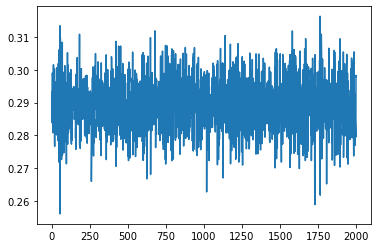

In [21]:
y = samples[2000:,0,2]
plt.plot(y)

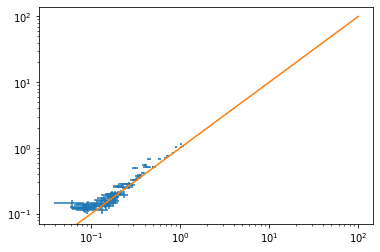

In [22]:
f_source = np.median(samples[2000:,:,:],axis=0)
f_err = np.percentile(samples[2000:,:,:],84,axis=0) - np.percentile(samples[2000:,:,:],16,axis=0)

mask_prior = np.array([name in prior.ID for name in lofar_orig['Source_Name']])

x = lofar_orig['Peak_flux'][mask_prior]*1000
xerr = lofar_orig['E_Peak_flux'][mask_prior]*1000
y = f_source
yerr = f_err.flatten()

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='')
plt.plot([0,100],[0,100])
plt.yscale('log')
plt.xscale('log')
plt.show()

([<aplpy.core.FITSFigure at 0x2aaddc3c8f90>],
 <Figure size 720x720 with 2 Axes>)

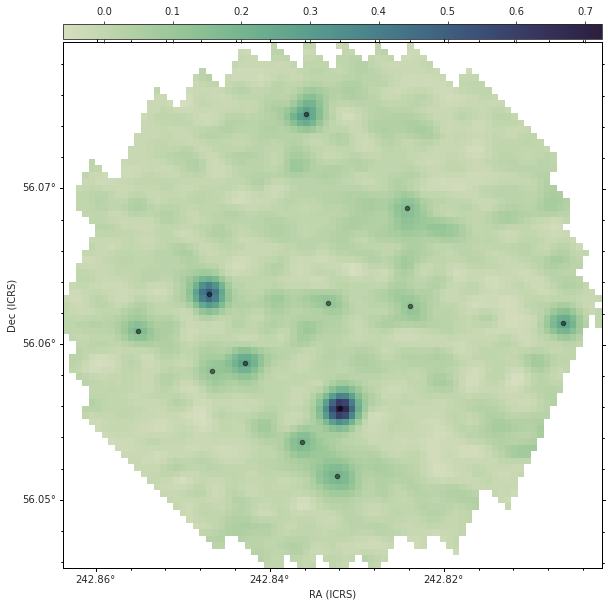

In [814]:
xidplus.plot_map([prior])

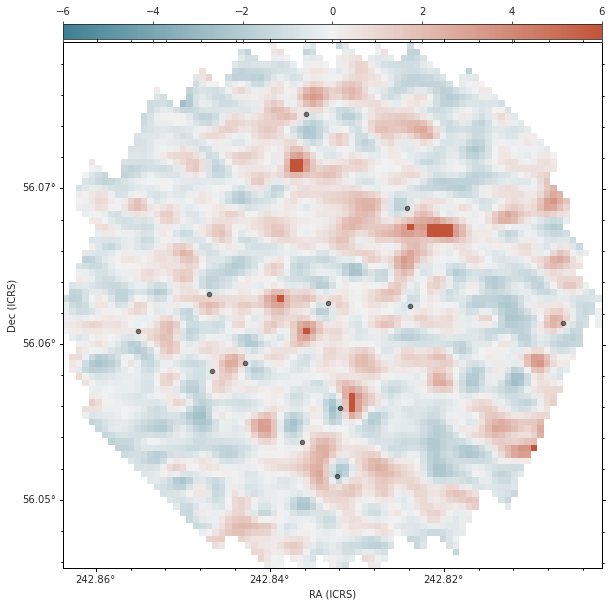

In [815]:
figs,fig=xidplus.plot_Bayes_pval_map([prior], posterior)

In [821]:
prior.prior_cat_name

'prior_cat'

In [817]:
test = xidplus.catalogue.create_MIPS_cat(posterior,prior,0)

ValueError: Illegal value: <bound method prior.prior_cat of <xidplus.prior.prior object at 0x2aaddbe26a10>>.

In [818]:
test

([<aplpy.core.FITSFigure at 0x2aadcb3c9110>],
 <Figure size 720x720 with 2 Axes>)

## Run XID+ on the model image prior list

In [8]:
prior_cat_model = Table.read('data/prior_cat_model.fits')
region_coords = Table.read('../data/radio_images/facet-offset.txt',format='ascii')
prior_cat_model[0]

id,ra,dec
bytes21,float64,float64
0,236.52111070583965,50.6899849658501


In [9]:
ras = lofar_orig['RA'][:1]#[n:n+1]
decs = lofar_orig['DEC'][:1]#[n:n+1]


ra_rad = ras/180*np.pi
dec_rad = decs/180*np.pi


orig_fluxes = lofar_orig['Peak_flux'][:1]#[n:n+1]
orig_ferr = lofar_orig['E_Peak_flux'][:1]#[n:n+1]

from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,30,15)



ra_rad = ras/180*np.pi
dec_rad = decs/180*np.pi
print(ra_rad)
print(dec_rad)

argmin = np.argmin( (region_coords['col1']-ra_rad)**2 + (region_coords['col2']-dec_rad)**2 )

ras = prior_cat_model['ra'] + region_coords['col3'][argmin]/3600*1.5
decs = prior_cat_model['dec'] + region_coords['col4'][argmin]/3600*1.5
ID = prior_cat_model['id']

        RA        
------------------
239.98990167026162        DEC       
-----------------
55.01456045936245
        RA       
-----------------
4.188613955683504
       DEC        
------------------
0.9601852165533588
        RA       
-----------------
4.188613955683504
       DEC        
------------------
0.9601852165533588


In [645]:
prior_model=xidplus.prior(radim_data,radim_err,radim_header,radim_header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior_model.prior_cat(ras,decs,'prior_cat',ID=ID,moc=moc)#Set input catalogue
prior_model.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

([<aplpy.core.FITSFigure at 0x2aadcc6d80d0>],
 <Figure size 720x720 with 2 Axes>)

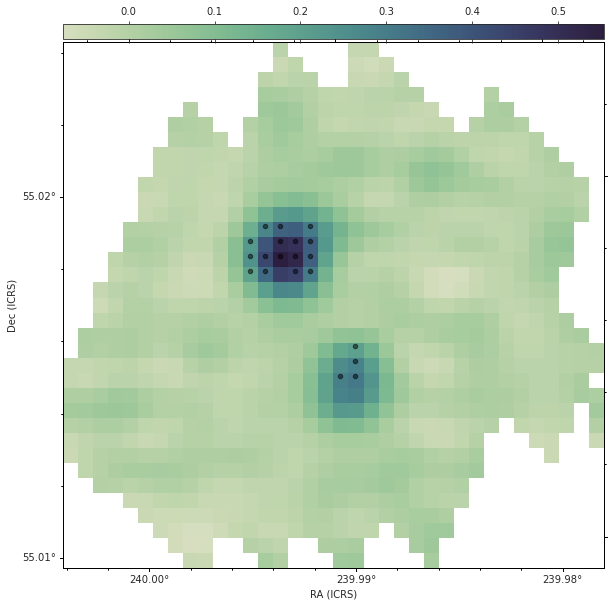

In [646]:
xidplus.plot_map([prior_model])

In [ ]:
pind = np.arange(0,n_size)#*(1.0/radim_pixsize)
prior.set_prf(prf.array,pind,pind)

In [ ]:
prior_model.get_pointing_matrix()
prior_model.upper_lim_map()

In [ ]:
from xidplus.numpyro_fit import LOFAR150
fit_model=LOFAR150.LOFAR_150(prior_model,num_samples=1000,num_warmup=1000)

In [ ]:
posterior_model = xidplus.posterior_numpyro(fit_model,[prior])

In [ ]:
figs,fig=xidplus.plot_Bayes_pval_map([prior_model], posterior_model)